### Module import

In [3]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

### Load image

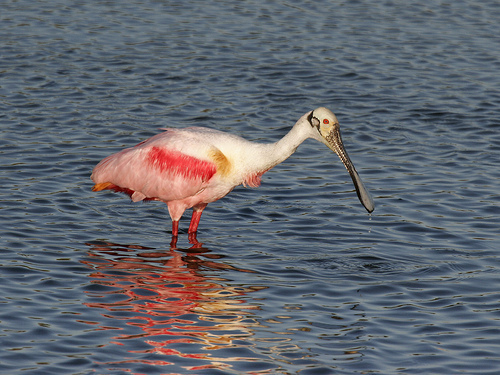

In [4]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = 'water-bird.JPEG'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [52]:
print(torch.from_numpy(np.array(pil_img)))

tensor([[[ 88, 101, 120],
         [ 86,  99, 118],
         [ 84,  97, 114],
         ...,
         [105, 114, 119],
         [109, 117, 120],
         [112, 120, 123]],

        [[ 83,  99, 115],
         [ 84, 100, 116],
         [ 85, 101, 116],
         ...,
         [ 96, 109, 118],
         [104, 114, 124],
         [109, 119, 128]],

        [[ 93, 103, 112],
         [ 92, 103, 109],
         [ 91, 102, 108],
         ...,
         [ 87,  97,  99],
         [ 93, 103, 105],
         [ 98, 106, 108]],

        ...,

        [[ 93, 109, 125],
         [ 96, 112, 128],
         [100, 116, 132],
         ...,
         [ 64,  82,  96],
         [ 61,  78,  94],
         [ 62,  77,  96]],

        [[101, 113, 127],
         [104, 116, 130],
         [106, 120, 133],
         ...,
         [ 57,  75,  89],
         [ 58,  74,  90],
         [ 60,  76,  92]],

        [[109, 116, 124],
         [111, 118, 126],
         [113, 120, 128],
         ...,
         [ 56,  71,  92],
        

In [49]:
np.asarray(pil_img)
pil_img = PIL.Image.open(img_path)
first_image = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
second_image = torch.from_numpy(np.array(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
# print(torch.all(torch.eq(first_image,second_image)))

tensor(True, device='cuda:0')


In [5]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [44]:
normed_torch_img.size()

torch.Size([1, 3, 224, 224])

### Load torchvision models and make model dictionaries

In [7]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval(), alexnet.cuda();

# vgg = models.vgg16(pretrained=True)
# vgg.eval(), vgg.cuda();

# resnet = models.resnet101(pretrained=True)
# resnet.eval(), resnet.cuda();

# densenet = models.densenet161(pretrained=True)
# densenet.eval(), densenet.cuda();

# squeezenet = models.squeezenet1_1(pretrained=True)
# squeezenet.eval(), squeezenet.cuda();


cam_dict = dict()

alexnet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
alexnet_gradcam = GradCAM(alexnet_model_dict, True)
alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

# vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
# vgg_gradcam = GradCAM(vgg_model_dict, True)
# vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
# cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

# resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
# resnet_gradcam = GradCAM(resnet_model_dict, True)
# resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
# cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

# densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
# densenet_gradcam = GradCAM(densenet_model_dict, True)
# densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
# cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

# squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
# squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
# squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
# cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### Feedforward image, calculate GradCAM/GradCAM++, and gather results

In [63]:
normed_torch_img.requires_grad

False

In [53]:
images = []

for gradcam, gradcam_pp in cam_dict.values():
    mask, logit = gradcam(normed_torch_img)
    mask = mask.cpu()
    heatmap, result = visualize_cam(mask, torch_img.cpu())
#     mask_pp, _ = gradcam_pp(normed_torch_img)
#     heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, result], 0))

images = make_grid(torch.cat(images, 0), nrow=5)

C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### Save and show results 

In [16]:
torch.zeros(1,3,244,244).shape

torch.Size([1, 3, 244, 244])

In [10]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%H_%M_%S")
print(dt_string)

12_08_13


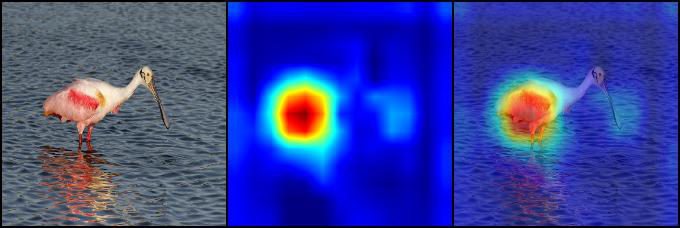

In [11]:

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

output_name = dt_string+img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)